# 🚗 Dynamic Pricing for Urban Parking Lots  
**Summer Analytics 2025 Capstone Project**  
**Team Name / Your Name**  

## 📌 Problem Statement  
Urban parking faces fluctuating demand. Fixed pricing leads to inefficiency.  
We aim to develop a real-time dynamic pricing model using real-world data, basic ML, and streaming simulation (via Pathway).

---

### 📊 Dataset Overview  
- Records: 18 samples/day × 73 days × 14 parking lots  
- Key columns: Occupancy, Capacity, Lat-Long, QueueLength, Traffic, Special Day, Vehicle Type  
---


In [40]:
#!pip install pathway
import pandas as ps
import numpy as np

In [2]:
#2. Simulated Streaming (based on your dataset)
import pathway as pw
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [9]:
import pandas as pd

# Load the uploaded file
df = pd.read_csv("dataset.csv")

# Rename to match Pathway schema
df = df.rename(columns={
    'SystemCodeNumber': 'lot_id',
    'Occupancy': 'occupancy',
    'Capacity': 'capacity'
})

# Add base price column
df['price'] = 10.0  # baseline price

# Save updated file for Pathway
df.to_csv("cleaned_dataset.csv", index=False)


In [12]:
#🔹 3. Define Schema
class ParkingSchema(pw.Schema):
    lot_id: str
    occupancy: int
    capacity: int
    price: float

In [13]:
#🔹 4. Read Data into a Pathway Table
data = pw.io.csv.read('cleaned_dataset.csv', schema=ParkingSchema)

***# 🔹 5. Model 1: Baseline Linear Pricing Function***
:  Price increases linearly with occupancy.

Formula:  
Price(t+1) = Price(t) + α ·[Occupancy/Capacity]


In [22]:
# Base price = 10, α = 2
alpha = 2

# Compute new price
output = data.select(
    lot_id = data.lot_id,
    occupancy = data.occupancy,
    capacity = data.capacity,
    old_price = data.price,
    new_price = data.price + alpha * (data.occupancy / data.capacity)
)

In [15]:
# Write result to a JSONL file
pw.io.jsonlines.write(
    output,
    filename="output.jsonl" # file will appear in Colab’s file panel
)

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [16]:
#🔹 7. Run the Pipeline (Batch or Streaming)
pw.run()  # Change to pw.run() for static mode
# pw.debug.compute_and_print
# pw.run()

Output()

KeyboardInterrupt: 

In [21]:
# Read and print the first few lines of the output file
with open("output.jsonl") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i >= 10:  # Only show first 10 rows to avoid overflow
            break


{"lot_id":"Others-CCCPS119a","occupancy":1277,"capacity":2803,"old_price":10.0,"new_price":10.911166607206564,"diff":1,"time":1751796088872}
{"lot_id":"BHMBCCMKT01","occupancy":49,"capacity":577,"old_price":10.0,"new_price":10.169844020797226,"diff":1,"time":1751796088872}
{"lot_id":"BHMNCPHST01","occupancy":772,"capacity":1200,"old_price":10.0,"new_price":11.286666666666667,"diff":1,"time":1751796088872}
{"lot_id":"BHMNCPHST01","occupancy":850,"capacity":1200,"old_price":10.0,"new_price":11.416666666666666,"diff":1,"time":1751796088872}
{"lot_id":"BHMMBMMBX01","occupancy":479,"capacity":687,"old_price":10.0,"new_price":11.394468704512374,"diff":1,"time":1751796088872}
{"lot_id":"BHMBCCTHL01","occupancy":400,"capacity":387,"old_price":10.0,"new_price":12.067183462532299,"diff":1,"time":1751796088872}
{"lot_id":"Others-CCCPS98","occupancy":1076,"capacity":3103,"old_price":10.0,"new_price":10.693522397679665,"diff":1,"time":1751796088872}
{"lot_id":"BHMBCCMKT01","occupancy":58,"capacity"

***# 🎯 Now Model 2: Demand-Based Pricing***  
Multiple demand features were incorporated:  
- Queue length  
- Traffic condition  
- Vehicle type  
- Special day

Final Price:  
Demand=α·[Occupancy/Capacity]+β·QueueLength−γ·Traffic+δ·IsSpecialDay+ε·VehicleTypeWeight

Use this demand value to adjust prices:
Pricet = BasePrice · (1 + λ · NormalizedDemand)


In [23]:
# 🎯 Now Model 2: Demand-Based Pricing
  # Using: Occupancy, Queue Length, Traffic, Special Day, and Vehicle Type
  # Dynamic Pricing formula:  Pricet = BasePrice⋅(1+λ⋅NormalizedDemand)
  # Demand = α × (occupancy / capacity)
      #  + β × (queue_length / max_queue)
      #  + γ × traffic_weight
      #  + δ × is_special_day
      #  + ε × vehicle_type_weight


Where:

| Feature      | Weight  | Transformation               |
| ------------ | ------- | ---------------------------- |
| Occupancy    | α = 0.4 | ratio (occ / cap)            |
| Queue        | β = 0.2 | normalized by 10             |
| Traffic      | γ = 0.2 | low=0.1, med=0.5, high=1.0   |
| Special Day  | δ = 0.1 | binary (0/1)                 |
| Vehicle Type | ε = 0.1 | car=1.0, bike=0.6, truck=1.5 |


In [32]:
# STEP1: Upload and Preprocess CSV
# To load original file
ds_csv = pd.read_csv("dataset.csv")

# To rename and select relevant columns
ds_csv = ds_csv.rename(columns={
    'SystemCodeNumber': 'lot_id',
    'Occupancy': 'occupancy',
    'Capacity': 'capacity',
    'QueueLength': 'queue',
    'TrafficConditionNearby': 'traffic',
    'IsSpecialDay': 'special_day',
    'VehicleType': 'vehicle_type'
})

# Assign base price = 10.0
ds_csv['price'] = 10.0

In [33]:
# STEP 2: Encode and Normalize Features
# Normalize queue (assuming max queue = 10)
ds_csv['queue_score'] = ds_csv['queue'] / 10

# Map traffic condition
traffic_map = {'low': 0.1, 'medium': 0.5, 'high': 1.0}
ds_csv['traffic_score'] = ds_csv['traffic'].map(traffic_map)

# Map vehicle type weight
vehicle_map = {'car': 1.0, 'bike': 0.6, 'truck': 1.5}
ds_csv['vehicle_score'] = ds_csv['vehicle_type'].map(vehicle_map)

# Normalize occupancy
ds_csv['occ_ratio'] = ds_csv['occupancy'] / ds_csv['capacity']

# Compute weighted demand score
ds_csv['demand_score'] = (
    0.4 * ds_csv['occ_ratio'] +
    0.2 * ds_csv['queue_score'] +
    0.2 * ds_csv['traffic_score'] +
    0.1 * ds_csv['special_day'] +
    0.1 * ds_csv['vehicle_score']
)

# Normalize demand to [0, 1] scale (optional for stability)
min_d, max_d = df['demand_score'].min(), ds_csv['demand_score'].max()
ds_csv['demand_norm'] = (ds_csv['demand_score'] - min_d) / (max_d - min_d)

# Calculate final price: base × (1 + λ × demand)
λ = 1.0  # sensitivity multiplier
ds_csv['new_price'] = ds_csv['price'] * (1 + λ * ds_csv['demand_norm'])

# Clip prices between 0.5x and 2x of base
ds_csv['new_price'] = ds_csv['new_price'].clip(lower=5.0, upper=20.0)

# Save as cleaned dataset for Pathway
# Drop rows with missing or blank new_price
ds_csv_final = ds_csv[['lot_id', 'occupancy', 'capacity', 'price', 'new_price']].copy()
ds_csv_final = ds_csv_final[ds_csv_final['new_price'].notnull()]  # removes NaNs
ds_csv_final = ds_csv_final[ds_csv_final['new_price'] != '']      # removes blanks

# Save cleaned CSV
ds_csv_final.to_csv("model2_dataset.csv", index=False)



In [34]:
# STEP 3: Pathway Pipeline to Output New Prices
# Define schema
class Model2Schema(pw.Schema):
    lot_id: str
    occupancy: int
    capacity: int
    price: float
    new_price: float

# Load into Pathway
data = pw.io.csv.read("model2_dataset.csv", schema=Model2Schema)

# You can add more processing here if needed

# Output results to JSONL
pw.io.jsonlines.write(data, filename="model2_output.jsonl")

# Run
pw.run()


Output()

KeyboardInterrupt: 

In [30]:
 #STEP 4: View Sample Output
with open("model2_output.jsonl") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i >= 10:
            break


{"lot_id":"BHMBCCMKT01","occupancy":146,"capacity":577,"price":10.0,"new_price":14.638486772462056,"diff":1,"time":1751797385058}
{"lot_id":"BHMEURBRD01","occupancy":387,"capacity":470,"price":10.0,"new_price":16.971584334832297,"diff":1,"time":1751797385058}
{"lot_id":"BHMNCPHST01","occupancy":213,"capacity":1200,"price":10.0,"new_price":11.057129071209859,"diff":1,"time":1751797385058}
{"lot_id":"Others-CCCPS119a","occupancy":210,"capacity":2803,"price":10.0,"new_price":12.273721161869657,"diff":1,"time":1751797385058}
{"lot_id":"BHMEURBRD01","occupancy":467,"capacity":470,"price":10.0,"new_price":17.667837759531256,"diff":1,"time":1751797385058}
{"lot_id":"Others-CCCPS119a","occupancy":626,"capacity":2803,"price":10.0,"new_price":11.449129390177324,"diff":1,"time":1751797385058}
{"lot_id":"Others-CCCPS105a","occupancy":851,"capacity":2009,"price":10.0,"new_price":12.063773134725423,"diff":1,"time":1751797385058}
{"lot_id":"BHMEURBRD01","occupancy":42,"capacity":470,"price":10.0,"new

***# 🎯MODEL 3  : Competitive Pricing with Rerouting Logic***

*# Objective: Is to adjust prices based on proximity to nearby lots and their prices.*

Assumption: Geospatial distance was used to identify nearby lots.  

**Logic**:
- Reroute if lot is full + nearby lots are cheaper & available  
- Increase price if competitors are expensive  


In [37]:
# STEP 1:
# Rename to unified structure
ds_csv = ds_csv.rename(columns={
    'SystemCodeNumber': 'lot_id',
    'Occupancy': 'occupancy',
    'Capacity': 'capacity',
    'Latitude': 'lat',
    'Longitude': 'lon',
    'QueueLength': 'queue',
    'TrafficConditionNearby': 'traffic',
    'IsSpecialDay': 'special_day',
    'VehicleType': 'vehicle_type'
})


In [38]:
# Encode traffic and vehicle
traffic_map = {'low': 0.1, 'medium': 0.5, 'high': 1.0}
vehicle_map = {'car': 1.0, 'bike': 0.6, 'truck': 1.5}

ds_csv['queue_score'] = ds_csv['queue'] / 10
ds_csv['traffic_score'] = ds_csv['traffic'].map(traffic_map)
ds_csv['vehicle_score'] = ds_csv['vehicle_type'].map(vehicle_map)
ds_csv['occ_ratio'] = ds_csv['occupancy'] / ds_csv['capacity']

# Compute demand score
ds_csv['demand_score'] = (
    0.4 * ds_csv['occ_ratio'] +
    0.2 * ds_csv['queue_score'] +
    0.2 * ds_csv['traffic_score'] +
    0.1 * ds_csv['special_day'] +
    0.1 * ds_csv['vehicle_score']
)

# Normalize demand
ds_csv['demand_norm'] = (ds_csv['demand_score'] - ds_csv['demand_score'].min()) / (ds_csv['demand_score'].max() - ds_csv['demand_score'].min())

# Compute new price
λ = 1.0
ds_csv['new_price'] = ds_csv['price'] * (1 + λ * ds_csv['demand_norm'])
ds_csv['new_price'] = ds_csv['new_price'].clip(lower=5.0, upper=20.0)


In [42]:
# STEP 3: Competitive Pricing Logic - Rerouting
# Define haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))


# Build competitive logic
reroute_flags = []
adjusted_prices = []

for i, row in ds_csv.iterrows():
    lat, lon = row['lat'], row['lon']
    my_price = row['new_price']
    my_occ_ratio = row['occ_ratio']

    # Find nearby lots within 1.0 km
    ds_csv['dist_km'] = haversine(lat, lon, ds_csv['lat'], ds_csv['lon'])
    nearby = ds_csv[(ds_csv['dist_km'] > 0.01) & (ds_csv['dist_km'] <= 1.0)]

    cheaper = nearby[(nearby['new_price'] < my_price) & (nearby['occ_ratio'] < 0.8)]

    # Default values
    reroute = 0
    adj_price = my_price

    if my_occ_ratio >= 0.95 and not cheaper.empty:
        reroute = 1
        adj_price = my_price * 0.9  # suggest rerouting: reduce price
    elif not cheaper.empty:
        adj_price = my_price * 0.95  # match competitor
    elif nearby['new_price'].mean() > my_price:
        adj_price = my_price * 1.05  # raise price carefully

    # Final bounds
    adj_price = max(5.0, min(adj_price, 20.0))

    reroute_flags.append(reroute)
    adjusted_prices.append(adj_price)


In [47]:
# Add to DataFrame
ds_csv['reroute'] = reroute_flags
ds_csv['final_price'] = adjusted_prices


In [48]:
 # STEP 4: Save as model3_dataset.csv
df_model3 = ds_csv[['lot_id', 'occupancy', 'capacity', 'price', 'final_price', 'reroute']]
df_model3.to_csv("model3_dataset.csv", index=False)


In [49]:
# Define schema
class Model3Schema(pw.Schema):
    lot_id: str
    occupancy: int
    capacity: int
    price: float
    final_price: float
    reroute: int

# Load into Pathway
data = pw.io.csv.read("model3_dataset.csv", schema=Model3Schema)

# Output
pw.io.jsonlines.write(data, filename="model3_output.jsonl")
pw.run()


Output()

KeyboardInterrupt: 

In [51]:
with open("model3_output.jsonl") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i > 10:
            break


{"lot_id":"Broad Street","occupancy":612,"capacity":690,"price":10.0,"final_price":13.84409008733791,"reroute":0,"diff":1,"time":1751799066408}
{"lot_id":"Others-CCCPS98","occupancy":936,"capacity":3103,"price":10.0,"final_price":5.0,"reroute":0,"diff":1,"time":1751799066408}
{"lot_id":"Others-CCCPS8","occupancy":758,"capacity":1322,"price":10.0,"final_price":12.43122008363741,"reroute":0,"diff":1,"time":1751799066408}
{"lot_id":"BHMNCPHST01","occupancy":670,"capacity":1200,"price":10.0,"final_price":15.28724716605751,"reroute":0,"diff":1,"time":1751799066408}
{"lot_id":"BHMBCCTHL01","occupancy":310,"capacity":387,"price":10.0,"final_price":13.510196637898018,"reroute":0,"diff":1,"time":1751799066408}
{"lot_id":"Others-CCCPS135a","occupancy":1579,"capacity":3883,"price":10.0,"final_price":5.0,"reroute":0,"diff":1,"time":1751799066408}
{"lot_id":"Others-CCCPS202","occupancy":858,"capacity":2937,"price":10.0,"final_price":5.0,"reroute":0,"diff":1,"time":1751799066408}
{"lot_id":"Others-C

***Pathway: Simulated Real-Time Streaming***

- Data ingested from CSV with simulated stream
- Output: `model3_output.jsonl`

We used:

```python
pw.io.csv.read(...)
pw.run()
pw.io.jsonlines.write(...)




***Real-Time Visualization (Bokeh)***

We plotted final price vs time for selected lots.  
Tooltip includes reroute status, timestamp, and price.

⬇Scroll to view chart below:
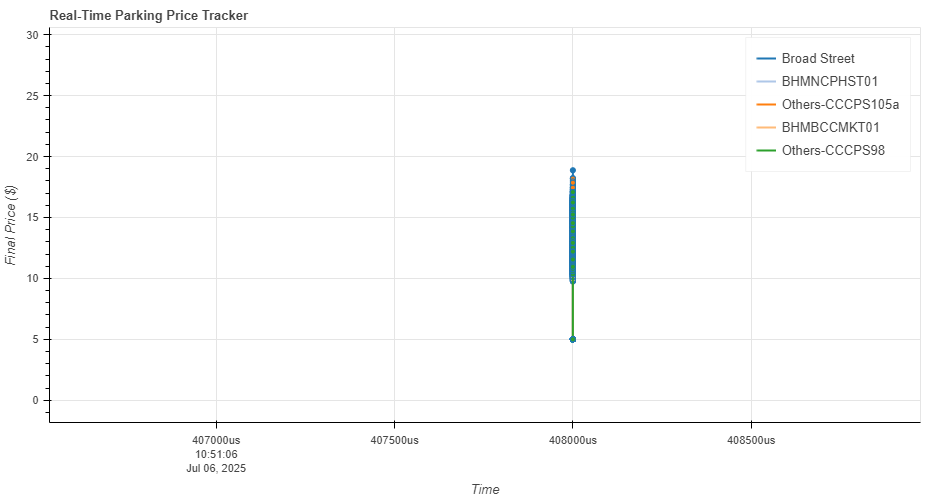

In [52]:
# !pip install bokeh --quiet--To insatll Bokeh


In [54]:
import json

# Load Pathway's output
with open("model3_output.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

df_bokeh = ps.DataFrame(data)

# Convert Pathway's 'time' field (ms) to datetime
df_bokeh['timestamp'] = ps.to_datetime(df_bokeh['time'], unit='ms')

# Optional sort
df_bokeh = df_bokeh.sort_values(by='timestamp')


In [55]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category20
output_notebook()

# Choose top N lots with most data points
top_lots = df_bokeh['lot_id'].value_counts().head(5).index.tolist()
df_filtered = df_bokeh[df_bokeh['lot_id'].isin(top_lots)]

# Plot
p = figure(title="Real-Time Parking Price Tracker", x_axis_type='datetime', width=950, height=500)
colors = Category20[20]

# Plot each lot's price over time
for i, lot in enumerate(top_lots):
    source = ColumnDataSource(df_filtered[df_filtered['lot_id'] == lot])
    p.line('timestamp', 'final_price', source=source, legend_label=lot, line_width=2, color=colors[i])
    p.circle('timestamp', 'final_price', source=source, fill_color=colors[i], size=5)

# Hover tooltip
p.add_tools(HoverTool(tooltips=[
    ("Lot", "@lot_id"),
    ("Time", "@timestamp{%F %T}"),
    ("Price", "@final_price{$0.00}"),
    ("Reroute", "@reroute"),
], formatters={'@timestamp': 'datetime'}))

p.legend.click_policy = "hide"
p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Final Price ($)"
show(p)


***Conclusion***

- Model 1 was a basic baseline  
- Model 2 captured real-time demand via multi-feature weighting  
- Model 3 introduced intelligent competitive pricing  
- Live visualization via Pathway + Bokeh verified real-time responsiveness  

**All models implemented with Python, Pandas, Numpy, Pathway**  
